In [2]:
# Instalar la librería
%pip install yfinance

import yfinance as yf

# Descarga datos del oro (GC=F)
df = yf.download("GC=F", start="2020-09-26", end="2025-09-26", interval="1d")

# Guardar en CSV
df.to_csv("gold_data.csv")
print("Archivo CSV guardado como gold_data.csv")


[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/var/folders/r9/xwlkxv7j0l7dcq4b4vs9c34w0000gn/T/ipykernel_1936/1784743917.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("GC=F", start="2020-09-26", end="2025-09-26", interval="1d")
[*********************100%***********************]  1 of 1 completed

Archivo CSV guardado como gold_data.csv


In [3]:
# descarga de datos
import yfinance as yf 

# Descargar datos históricos del S&P 500 (^GSPC)
sp500 = yf.download("^GSPC", start="2020-01-01", end="2025-09-25", interval="1d")

# Guardar en CSV
sp500.to_csv("sp500.csv")

print("✅ Archivo CSV del S&P 500 guardado como sp500.csv")
print(sp500.head())  # Muestra las primeras filas para verificar


/var/folders/r9/xwlkxv7j0l7dcq4b4vs9c34w0000gn/T/ipykernel_1936/1227420507.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start="2020-01-01", end="2025-09-25", interval="1d")
[*********************100%***********************]  1 of 1 completed

✅ Archivo CSV del S&P 500 guardado como sp500.csv
Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2020-01-02  3257.850098  3258.139893  3235.530029  3244.669922  3459930000
2020-01-03  3234.850098  3246.149902  3222.340088  3226.360107  3484700000
2020-01-06  3246.280029  3246.840088  3214.639893  3217.550049  3702460000
2020-01-07  3237.179932  3244.909912  3232.429932  3241.860107  3435910000
2020-01-08  3253.050049  3267.070068  3236.669922  3238.590088  3726840000


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def prepare_gold_sp500(
    gold_path="../data/raw/gold_data.csv",
    sp500_path="../data/raw/sp500.csv",
    save_path="../data/processed/gold_sp500_clean.csv",
    plot=True
):
    """
    Carga, limpia, combina y genera features entre el Oro (GC=F) y el S&P 500 (^GSPC).

    Proceso:
      - Cargar CSVs
      - Parsear fechas (soporta distintos formatos)
      - Combinar datasets por fecha
      - Crear features:
          * Rendimientos diarios
          * Lags (1 y 2)
          * Moving averages (MA-5)
          * Volatilidad (rolling std)
      - Limpiar datos nulos
      - Guardar CSV final
      - Graficar series originales

    Retorna:
        pd.DataFrame procesado
    """

    # --- 1. Cargar datasets ---
    gold = pd.read_csv(gold_path)
    sp500 = pd.read_csv(sp500_path)

    # --- 2. Parseo robusto de fechas ---
    gold["Date"] = pd.to_datetime(gold["Date"], dayfirst=True, errors="coerce")
    sp500["Date"] = pd.to_datetime(sp500["Date"], dayfirst=True, errors="coerce")

    gold.dropna(subset=["Date"], inplace=True)
    sp500.dropna(subset=["Date"], inplace=True)

    # --- 3. Selección de columnas ---
    gold = gold[["Date", "Close"]].rename(columns={"Close": "Gold_Close"})
    sp500 = sp500[["Date", "Close"]].rename(columns={"Close": "SP500_Close"})

    # --- 4. Unión por fecha ---
    df = pd.merge(gold, sp500, on="Date", how="inner")
    df.sort_values("Date", inplace=True)
    df.reset_index(drop=True, inplace=True)

    print(f"📅 Rango temporal: {df['Date'].min().date()} → {df['Date'].max().date()}")
    print(f"📊 Total de días: {len(df)}")

    # --- 5. Feature Engineering ---
    # Rendimientos diarios
    df["Gold_Return"] = df["Gold_Close"].pct_change()
    df["SP500_Return"] = df["SP500_Close"].pct_change()

    # Lags
    for lag in range(1, 3):
        df[f"Gold_Close_Lag{lag}"] = df["Gold_Close"].shift(lag)
        df[f"SP500_Close_Lag{lag}"] = df["SP500_Close"].shift(lag)

    # Moving Averages
    df["Gold_MA5"] = df["Gold_Close"].rolling(5).mean()
    df["SP500_MA5"] = df["SP500_Close"].rolling(5).mean()

    # Volatilidad
    df["Gold_Volatility_5"] = df["Gold_Close"].pct_change().rolling(5).std()

    # Lags de returns
    df["SP500_Return_Lag1"] = df["SP500_Close"].pct_change().shift(1)

    # --- 6. Limpiar ---
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    # --- 7. Guardar resultado ---
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    df.to_csv(save_path, index=False)
    print(f"✅ Datos procesados guardados en: {save_path}")

    # --- 8. Plot opcional ---
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(df["Date"], df["Gold_Close"], label="Gold", color="gold")
        plt.plot(df["Date"], df["SP500_Close"], label="S&P 500", color="blue")
        plt.title("Evolución diaria del Oro y el S&P 500")
        plt.xlabel("Fecha")
        plt.ylabel("Precio de cierre")
        plt.legend()
        plt.grid(True)
        plt.show()

    return df

📅 Rango temporal: 2020-09-28 → 2025-09-24
📊 Total de días: 1254
✅ Datos procesados guardados en: ../data/processed/gold_sp500_clean.csv


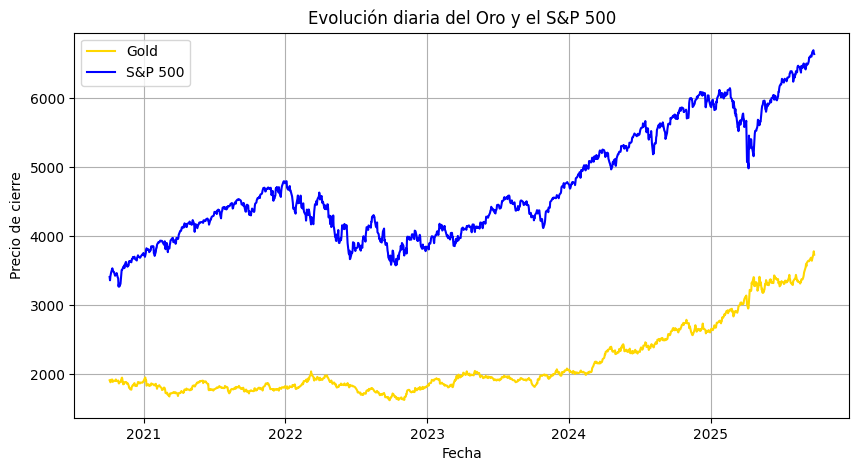

,Date,Gold_Close,SP500_Close,Gold_Return,SP500_Return,Gold_Close_Lag1,SP500_Close_Lag1,Gold_Close_Lag2,SP500_Close_Lag2,Gold_MA5,SP500_MA5,Gold_Volatility_5,SP500_Return_Lag1
0,2020-10-05,1912.500000,3408.600098,0.006473,0.017973,1900.199951,3348.419922,1908.400024,3380.800049,1900.580005,3367.258008,0.007718,-0.009578
1,2020-10-06,1901.099976,3360.969971,-0.005961,-0.013974,1912.500000,3408.600098,1900.199951,3348.419922,1901.939990,3372.358008,0.007561,0.017973
2,2020-10-07,1883.599976,3419.439941,-0.009205,0.017397,1901.099976,3360.969971,1912.500000,3408.600098,1901.159985,3383.645996,0.008696,-0.013974
3,2020-10-08,1888.599976,3446.830078,0.002654,0.008010,1883.599976,3419.439941,1901.099976,3360.969971,1897.199976,3396.852002,0.006448,0.017397
4,2020-10-09,1919.500000,3477.139893,0.016361,0.008794,1888.599976,3446.830078,1883.599976,3419.439941,1901.059986,3422.595996,0.010193,0.008010


In [7]:
df = prepare_gold_sp500()
df.head()